## Convolution

Assume we have a function $f(t)$, and its observable $g(t)$. The observable has a delayed response, given by the kernel $h(t)$

$g(t) = \int_{-\infty}^{\infty}f(t-\tau)h(\tau)d\tau$

The kernel $h(t)$ is
* causal, meaning that $h(t)=0 \; \forall t<0$
* finite, meaning that $\int_{0}^{\infty}h(t)dt = C$ for some finite $C$

Given causality, we can adjust the integral to

$g(t) = \int_{0}^{\infty}f(t-\tau)h(\tau)d\tau$

## Unobserved Past

We will only be observing $g(t)$ within a finite time interval $t \in [0, T]$. However, its value will, in general, be affected by the previous values of $f(t)$. In order to proceed, we will assume that this is not the case, and that $f(t) = 0 \; \forall t < 0$. If this is not the case, we must make a reasonable assumption of the values of $f(t)$ for $t<0$, and subtract their effect from the observable function. 

$\tilde{g}(t) = g(t) - \int_{t}^{\infty}f(t-\tau)h(\tau)d\tau$

We will assume that $\tilde{g}(t)$ is the observable function. Then

$\tilde{g}(t) = \int_{0}^{t}f(t-\tau)h(\tau)d\tau$

## Discretization

Time-observations cannot be performed continuously. A typical scenario would integrate the input signal over equally-spaced time intervals $\Delta t$, and then divide by $\Delta t$ to compute the average signal within each interval.

Let us
* Assume that $f(t)$ is a piecewise-constant function $f(t)=f_i$ where $i = \lfloor \frac{t}{\Delta t} \rfloor$
* Define $h_i = \int_{i\Delta t}^{(i+1)\Delta t} h(t) dt$
* Define $g_i = \tilde{g}(i\Delta t)$

Then the convolution becomes

$g_i = \sum_{j=0}^{i} f_{i-j} h_j = \sum_{j=0}^n H_{ij} f_j$

Where $H_{ij} = h_{i-j}\Theta(i\geq j)$ is the convolution matrix. We can thus solve the liner system for $f_i$.

## Additional issues

### Noise

In case of added noise, the observable function becomes $g = H f + \nu$ and can be addressed by solving least squares, namely
$$f = \mathrm{argmin} \bigl|g - Hf \bigr|^2 = (H^TH)^{-1} H^T g$$

### Regularization

It is not ok for the values of $f$ to be below 0, or to be excessively large. Further, it may be sensible to consider fitness of points close to the beginning of the trial as less impactful, as they are affected by unknown past. Also the points at the end of the trial, as they have less points to be computed from

In [1]:
# Noob experiment

# 1) Generate some fft random function
# 2) Compute its binned average given delta_t
# 3) Compute also its convolution given tau
# 4) Compute binned convolution for the same delta_t
# 5) Compute also binned kernel for the same delta_t
# 6) [Optional] Apply noise to the binned convolution
# 7) Apply scipy deconvolution method given binned convolution and binned kernel
# 8) Compare error between binned average and deconvolution, as function of tau and delta_t

/opt/anaconda3/envs/py36qt5/lib/python3.6/site-packages/matplotlib/figure.py:2022: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


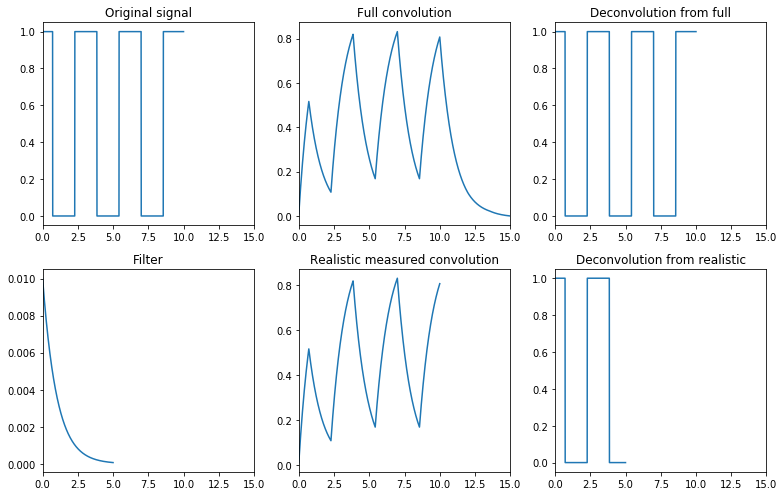

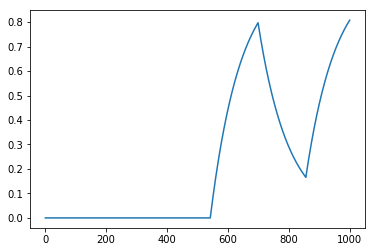

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scipy.signal

def exp_ker(t, tau):
    return np.exp(-t/tau)/tau

# Problem size
T_SIGNAL = 10
T_KERNEL = T_SIGNAL / 2

DT = 0.01
t_signal = np.arange(0, T_SIGNAL + DT, DT)
t_kernel = np.arange(0, T_KERNEL + DT, DT)
t_conv_full = np.arange(0, T_SIGNAL + T_KERNEL + DT, DT)
t_deconv_scipy = np.arange(0, T_SIGNAL - T_KERNEL + DT, DT)
NPOINT = len(t_signal)

# Box Signal
signal = np.zeros(NPOINT)
signal[np.sin(t_signal - 1.5)**2 > 0.5] = 1

# Kernel
TAU = 1.0
kernel = exp_ker(t_kernel, TAU)
kernel /= np.sum(kernel)

# Convolve
sig_conv_full = scipy.signal.convolve(signal, kernel, mode='full')
sig_conv_real = sig_conv_full[:NPOINT]

# Deconvolve
sig_deconv_full, sig_rem_full = scipy.signal.deconvolve(sig_conv_full, kernel)
sig_deconv_real, sig_rem_real = scipy.signal.deconvolve(sig_conv_real, kernel)

fig, ax = plt.subplots(nrows=2, ncols=3, figsize = (11,7), tight_layout=True)
ax[0][0].plot(t_signal, signal)
ax[1][0].plot(t_kernel, kernel)
ax[0][1].plot(t_conv_full, sig_conv_full)
ax[1][1].plot(t_signal, sig_conv_real)
ax[0][2].plot(t_signal, sig_deconv_full)
ax[1][2].plot(t_deconv_scipy, sig_deconv_real)

ax[0][0].set_title("Original signal")
ax[1][0].set_title("Filter")
ax[0][1].set_title("Full convolution")
ax[1][1].set_title("Realistic measured convolution")
ax[0][2].set_title("Deconvolution from full")
ax[1][2].set_title("Deconvolution from realistic")

ax[0][0].set_xlim([0, T_SIGNAL+T_KERNEL])
ax[1][0].set_xlim([0, T_SIGNAL+T_KERNEL])
ax[0][1].set_xlim([0, T_SIGNAL+T_KERNEL])
ax[1][1].set_xlim([0, T_SIGNAL+T_KERNEL])
ax[0][2].set_xlim([0, T_SIGNAL+T_KERNEL])
ax[1][2].set_xlim([0, T_SIGNAL+T_KERNEL])

plt.show()

plt.figure()
plt.plot(sig_rem_real)
plt.show()

# Also, can SciPy deconv handle noise?

It cant :D

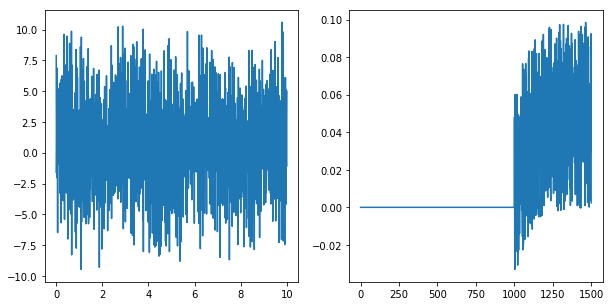

In [11]:
# Some deconvolution with noise
sig_conv_full_noisy = sig_conv_full + 0.1 * np.random.uniform(0, 1, len(sig_conv_full))
sig_deconv_full_noisy, sig_rem_full_noisy = scipy.signal.deconvolve(sig_conv_full_noisy, kernel)

fig, ax = plt.subplots(ncols=2, figsize=(10,5))
ax[0].plot(t_signal, sig_deconv_full_noisy)
ax[1].plot(sig_rem_full_noisy)
plt.show()